In [0]:
#Definir Librerias:
import cv2 
import numpy as np
import os
import random
from random import shuffle
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import asarray
import seaborn as sns
%matplotlib inline

In [0]:
#Descomprimir imágenes de TRAIN:
!unzip train_mask.zip
!unzip train_nomask.zip
#Descomprimir imágenes de TEST:
!unzip test_mask.zip
!unzip test_nomask.zip

In [114]:
#Almacenar imágenes de TRAIN en lista de objetos:
train_mask = ['train_mask/{}'.format(i) for i in os.listdir('train_mask') if 'train_mask' in i]
train_nomask = ['train_nomask/{}'.format(i) for i in os.listdir('train_nomask') if 'train_nomask' in i]
#Almacenar imágenes de TEST en lista de objetos:
test_mask = ['test_mask/{}'.format(i) for i in os.listdir('test_nomask')]
test_nomask = ['test_nomask/{}'.format(i) for i in os.listdir('test_nomask')]
#Juntar ambos datasets de imágenes en una sola lista de objetos para TRAIN y TEST:
train = train_mask + train_nomask
test = test_mask + test_nomask
#Mezclamos el dataset de TRAIN forma random:
shuffle(train)
#Validamos:
print ("Tamaño del DataSet de TRAIN", len(train))
print ("Tamaño del DataSet de TEST", len(test))
#Para evitar quedarnos sin memoria, limpiamos las variables que no estamos usando:
del train_mask
del train_nomask
del test_mask
del test_nomask
gc.collect()

Tamaño del DataSet de TRAIN 2554
Tamaño del DataSet de TEST 140


11650

In [0]:
#Formateamos las imagenes con la siguiente función:
def PreProcesamiento(data_set):
  #Definimos el tamaño al que las imagenes deben ser escaladas:
  rows = 160
  cols = 160
  #Inicializamos el arreglo de features:
  X = []
  #Inicializamos el arreglo de labels:
  Y = []
  #Procesamos las imagenes de la lista de objetos:
  for img in data_set:
    X.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (rows, cols), interpolation = cv2.INTER_CUBIC))
    if 'train_mask' in img:
      Y.append(1)
    elif 'train_nomask' in img:
      Y.append(0)
  
  return X, Y

In [0]:
x, y = PreProcesamiento(train)

Label: 0
Label: 0
Label: 0
Label: 1
Label: 1


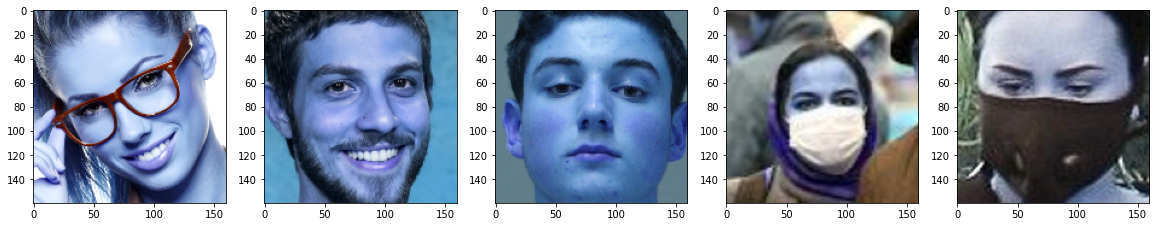

In [117]:
#Ploteamos algunas imágenes de los datasets:
plt.figure(figsize = (20,10))
columns = 5
for i in range (columns):
  plt.subplot(5/columns+1,columns,i +1 )
  plt.imshow(x[i])
  print('Label:', y[i])

La forma de los features de TRAIN son (2554, 160, 160, 3)
La forma de los labes de TRAIN son (2554,)


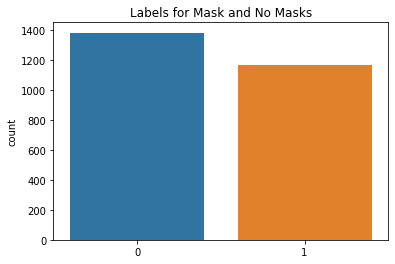

In [118]:
del train
gc.collect()
x = np.array(x)
y = np.array(y)
sns.countplot(y)
plt.title('Labels for Mask and No Masks')
print('La forma de los features de TRAIN son',x.shape)
print('La forma de los labes de TRAIN son',y.shape)

In [119]:
#Partimos el dataset en datos de TRAIN y VALIDATION:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=2)
print('La forma de X_train es',X_train.shape)
print('La forma de X_val es',X_val.shape)
print('La forma de Y_train es',Y_train.shape)
print('La forma de Y_val es',Y_val.shape)
del x
del y
gc.collect()

La forma de X_train es (2043, 160, 160, 3)
La forma de X_val es (511, 160, 160, 3)
La forma de Y_train es (2043,)
La forma de Y_val es (511,)


2153

In [0]:
# Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint

#Aumentamos la data de TRAIN ya que tenemos pocas imagánes y las normalizamos:
train_datagenerator = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                         height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                         horizontal_flip = True,)
#Solo normalizamos la data de Validación:
val_datagenerator = ImageDataGenerator(rescale = 1./255)

#Aplicamos los objetos de Data Generator a nuestos datasets:
train_gen = train_datagenerator.flow(X_train, Y_train, batch_size = 64)
val_gen = train_datagenerator.flow(X_val, Y_val, batch_size = 64)

In [121]:
#Definimos la arquitectura de la Primera CNN:
n_train = len(X_train)
n_val = len(X_val)
batch_size = 32
learning_rate = 0.01

nb = math.ceil(len(X_train)/batch_size) # Nro de batches

model = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(160,160,3)),
    MaxPool2D((2,2)),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 20, 128)     

In [27]:
# Trainning
history = model.fit_generator(train_gen, steps_per_epoch=n_train//batch_size, epochs=20, validation_data=val_gen,validation_steps=n_val//batch_size )

Epoch 1/20
63/63 [==============================] - 27s 421ms/step - loss: 10.5227 - acc: 0.5298 - val_loss: 0.6613 - val_acc: 0.6413
Epoch 2/20
63/63 [==============================] - 26s 420ms/step - loss: 0.7586 - acc: 0.5465 - val_loss: 0.6893 - val_acc: 0.5939
Epoch 3/20
63/63 [==============================] - 26s 420ms/step - loss: 0.7720 - acc: 0.5476 - val_loss: 0.6910 - val_acc: 0.5772
Epoch 4/20
63/63 [==============================] - 26s 413ms/step - loss: 0.9144 - acc: 0.5952 - val_loss: 0.6270 - val_acc: 0.5000
Epoch 5/20
63/63 [==============================] - 26s 412ms/step - loss: 0.6048 - acc: 0.6979 - val_loss: 0.4097 - val_acc: 0.8038
Epoch 6/20
63/63 [==============================] - 26s 412ms/step - loss: 0.5279 - acc: 0.7594 - val_loss: 0.6208 - val_acc: 0.7557
Epoch 7/20
63/63 [==============================] - 26s 413ms/step - loss: 0.5344 - acc: 0.7541 - val_loss: 0.4595 - val_acc: 0.7589
Epoch 8/20
63/63 [==============================] - 26s 409ms/step -

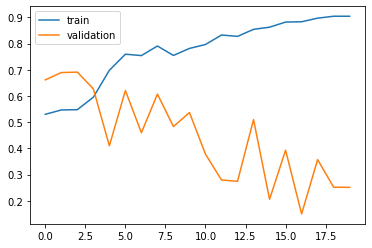

In [51]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend();

In [31]:
#Definimos la arquitectura de la Segunda CNN:
n_train = len(X_train)
n_val = len(X_val)
batch_size = 32
learning_rate = 0.01

nb = math.ceil(len(X_train)/batch_size) # Nro de batches

model2 = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(160,160,3)),
    MaxPool2D((2,2)),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 20, 20, 128)      

In [33]:
# Trainning
history2 = model2.fit_generator(train_gen, steps_per_epoch=n_train//batch_size, epochs=20, validation_data=val_gen,validation_steps=n_val//batch_size )

Epoch 1/20
63/63 [==============================] - 27s 432ms/step - loss: 0.2577 - acc: 0.8866 - val_loss: 0.2192 - val_acc: 0.8697
Epoch 2/20
63/63 [==============================] - 27s 433ms/step - loss: 0.2380 - acc: 0.9003 - val_loss: 0.2867 - val_acc: 0.9092
Epoch 3/20
63/63 [==============================] - 27s 431ms/step - loss: 0.2193 - acc: 0.9140 - val_loss: 0.2516 - val_acc: 0.9102
Epoch 4/20
63/63 [==============================] - 27s 424ms/step - loss: 0.1836 - acc: 0.9314 - val_loss: 0.2866 - val_acc: 0.8779
Epoch 5/20
63/63 [==============================] - 27s 425ms/step - loss: 0.1862 - acc: 0.9301 - val_loss: 0.2825 - val_acc: 0.9092
Epoch 6/20
63/63 [==============================] - 27s 421ms/step - loss: 0.1609 - acc: 0.9386 - val_loss: 0.4328 - val_acc: 0.8998
Epoch 7/20
63/63 [==============================] - 26s 415ms/step - loss: 0.1538 - acc: 0.9438 - val_loss: 0.2330 - val_acc: 0.9415
Epoch 8/20
63/63 [==============================] - 26s 419ms/step - 

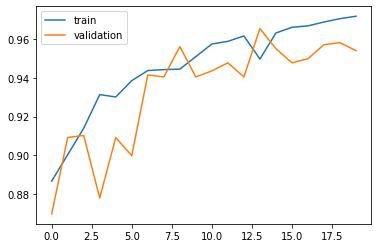

In [81]:
plt.plot(history2.history['acc'], label='train')
plt.plot(history2.history['val_acc'], label='validation')
plt.legend();

In [138]:
#Definimos la arquitectura de la Tercera CNN:
n_train = len(X_train)
n_val = len(X_val)
batch_size = 32
learning_rate = 0.001

nb = math.ceil(len(X_train)/batch_size) # Nro de batches

model3 = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(160,160,3)),
    MaxPool2D((2,2)),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Definimos el tipo de checkpoint:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#Definimos el optimizador y compilamos:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
model3.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 20, 20, 128)     

In [139]:
# Trainning
history3 = model3.fit_generator(train_gen, steps_per_epoch=n_train//batch_size, epochs=50, validation_data=val_gen,validation_steps=n_val//batch_size, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_acc improved from -inf to 0.82899, saving model to weights-improvement-01-0.83.hdf5

Epoch 00002: val_acc improved from 0.82899 to 0.87996, saving model to weights-improvement-02-0.88.hdf5

Epoch 00003: val_acc improved from 0.87996 to 0.89562, saving model to weights-improvement-03-0.90.hdf5

Epoch 00004: val_acc improved from 0.89562 to 0.90814, saving model to weights-improvement-04-0.91.hdf5

Epoch 00005: val_acc improved from 0.90814 to 0.92484, saving model to weights-improvement-05-0.92.hdf5

Epoch 00006: val_acc improved from 0.92484 to 0.93528, saving model to weights-improvement-06-0.94.hdf5

Epoch 00007: val_acc improved from 0.93528 to 0.93633, saving model to weights-improvement-07-0.94.hdf5

Epoch 00008: val_acc improved from 0.93633 to 0.95094, saving model to weights-improvement-08-0.95.hdf5

Epoch 00009: val_acc did not improve from 0.95094

Epoch 00010: val_acc improved from 0.95094 to 0.96242, saving model to weights-improvement-10-0.96.hdf5

Epoch 

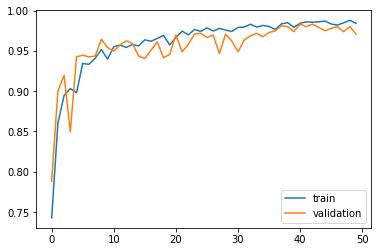

In [126]:
plt.plot(history3.history['acc'], label='train')
plt.plot(history3.history['val_acc'], label='validation')
plt.legend();

In [0]:
#Almacenar imágenes de TEST en lista de objetos:
test_mask = ['test2/{}'.format(i) for i in os.listdir('test2') if 'train_mask' in i]
test_nomask = ['test2/{}'.format(i) for i in os.listdir('test2') if 'train_nomask' in i]
test = test_mask + test_nomask
shuffle(test)
X, Y = PreProcesamiento(test)
x = np.array(X)/255
y = np.array(Y)

In [128]:
print('La forma de X_train es',x.shape)
print('La forma de X_val es',y.shape)

La forma de X_train es (140, 160, 160, 3)
La forma de X_val es (140,)


Label: 0
Label: 0
Label: 0
Label: 1
Label: 0


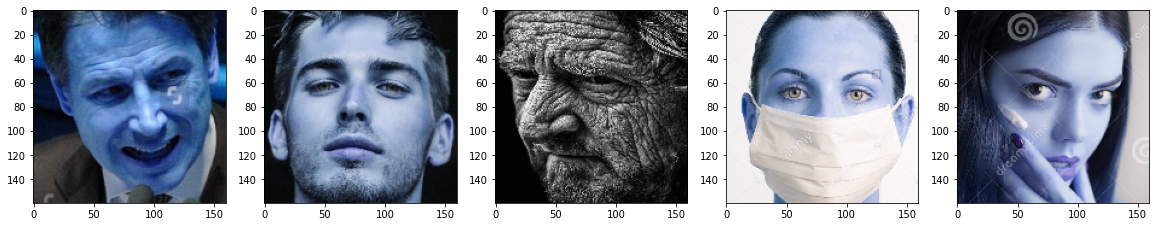

In [129]:
#Ploteamos algunas imágenes de los datasets:
plt.figure(figsize = (20,10))
columns = 5
for i in range (columns):
  plt.subplot(5/columns+1,columns,i +1 )
  plt.imshow(x[i])
  print('Label:', y[i])

In [130]:
mask = 0
i = 0
correctos = 0
incorrectos = 0
for i in range (len(x)):
  im = x[i]
  im = im[None]
  resultado = model3.predict(im)
  if (resultado > 0.5):
      mask = 1
  else:
      mask = 0
  if (mask == y[i]):
    correctos = correctos + 1
  else:
    incorrectos = incorrectos + 1
print("Predicciones Correctas:",correctos)
print("Predicciones Incorrectas:",incorrectos)

Predicciones Correctas: 136
Predicciones Incorrectas: 4


In [0]:
#REFERENCIAS:
# Transfer Learning with KERAS:
#https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/
# Data Preprocesing with KERAS:
#https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
# Checkpoint with KERAS:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/ 